In [3]:
import string

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.basemap import Basemap
from numpy import *
from matplotlib.pyplot import *

## Parameters

In [15]:
#zoneAnalysis = "Japan"
zoneAnalysis = "Gulf of Mexico"
maxLon, minLon, maxLat, minLat = 0,0,0,0
minYear = 1998
maxYear = 2015

if (zoneAnalysis == "Gulf of Mexico"):
    maxLon = 280
    minLon = 258
    maxLat = 30
    minLat = 18
else:
    maxLon = 145
    minLon = 120
    maxLat = 40
    minLat = 20

## Plot methods

In [5]:
# function to plot images
def plot_im(lon,lat,im,size_points,var_name):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

# IBTRACS Dataset loading

## Data loading

In [6]:
data = pd.read_csv("data/ibtracs.since1980.list.v04r00.csv")
data.drop(index=[0], inplace=True)

C:\Users\guyll\AppData\Local\Temp\ipykernel_18308\1609384494.py:1: DtypeWarning: Columns (1,2,8,9,14,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/ibtracs.since1980.list.v04r00.csv")


## Preprocessing

In [16]:
#time conversion
data.SEASON = data.SEASON.astype("int32")
data.ISO_TIME = pd.to_datetime(data.ISO_TIME)
data["NSEC_TIME"] = data.ISO_TIME.astype("int64")
data.NSEC_TIME

1          315532800000000000
2          315543600000000000
3          315554400000000000
4          315565200000000000
5          315576000000000000
                 ...         
286370    1673114400000000000
286371    1673125200000000000
286372    1673136000000000000
286373    1673146800000000000
286374    1673157600000000000
Name: NSEC_TIME, Length: 286374, dtype: int64

In [17]:
#coord conversion
data.LAT = data.LAT.astype("float32")
data.LAT = data.LAT.round(3)
data.LON = data.LON.astype("float32")
data.LON = data.LON.round(3)
data.loc[data.LON < 0, 'LON'] = data[data.LON < 0].LON + 360

#category creation
#using wind speed from USA_WIND (instead of WMO_WIND) since there are less unknown data
#print(data.USA_WIND.describe())
#print(data.WMO_WIND.describe())
data.loc[data.USA_WIND == ' ', "USA_WIND"] = "-1"
data['USA_WIND'] = data['USA_WIND'].astype("float32")
windSpeedBins = [-10, 0, 34, 64, 83, 96, 113, 137, 300]
categoryLabels = ["Unknown", "TD", "TS", "1", "2", "3", "4", "5"]
data["CATEGORY"] = pd.cut(data['USA_WIND'], bins=windSpeedBins, labels=categoryLabels)

dataTime = data[(data.SEASON >= minYear) & (data.SEASON <= maxYear)]
dataSpace = dataTime[(dataTime.LON > minLon) & (dataTime.LON < maxLon) & (dataTime.LAT > minLat) & (dataTime.LAT < maxLat)]

dataSpace = dataSpace.drop(index=dataSpace.loc[dataSpace.CATEGORY == "Unknown"].index)

dataSpace.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR,NSEC_TIME,CATEGORY
133928,1998233N25268,1998,52,NaN,GM,CHARLEY,1998-08-21 06:00:00,TS,25.299999,267.700012,...,,,,,,,15,270,903679200000000000,TD
133929,1998233N25268,1998,52,NaN,GM,CHARLEY,1998-08-21 09:00:00,TS,25.306000,266.864990,...,,,,,,,14,274,903690000000000000,TD
133930,1998233N25268,1998,52,NaN,GM,CHARLEY,1998-08-21 12:00:00,TS,25.400000,266.200012,...,,,,,,,10,290,903700800000000000,TD
133931,1998233N25268,1998,52,NaN,GM,CHARLEY,1998-08-21 15:00:00,TS,25.646999,265.804993,...,,,,,,,9,314,903711600000000000,TS
133932,1998233N25268,1998,52,NaN,GM,CHARLEY,1998-08-21 18:00:00,TS,26.000000,265.500000,...,,,,,,,10,319,903722400000000000,TS


## Unique cyclones extraction

In [18]:
cyclonesMapData = dataSpace[["LAT", "LON", "SID", "USA_WIND", "NSEC_TIME"]].groupby(["SID"], as_index=False).agg(LAT = ("LAT", "mean"), LON = ("LON", 'mean'), SEC_TIME = ("NSEC_TIME", 'mean'), USA_WIND = ("USA_WIND", 'max'))

cyclonesMapData["SEC_TIME"] = pd.to_datetime(cyclonesMapData["SEC_TIME"], unit='ns')
cyclonesMapData[cyclonesMapData["USA_WIND"] > 125].count()

SID         8
LAT         8
LON         8
SEC_TIME    8
USA_WIND    8
dtype: int64

# Map image plotting

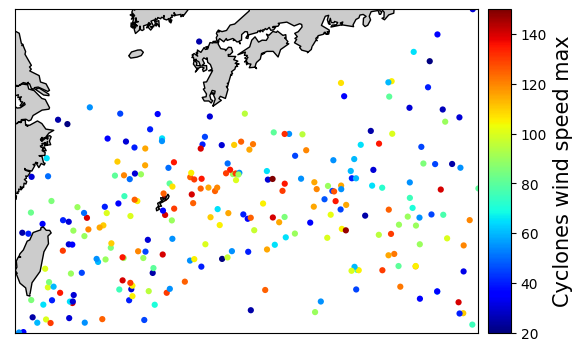

In [81]:
plot_im(cyclonesMapData.LON, cyclonesMapData.LAT, cyclonesMapData.USA_WIND, 20, "Unique cyclones with max wind speed")

# Descriptive analysis plotting

In [35]:
# Adding more columns about time and cyclone category (from average wind speed)
cyclonesMapData["MONTH_TIME"] = cyclonesMapData["SEC_TIME"].dt.month
cyclonesMapData["YEAR_TIME"] = cyclonesMapData["SEC_TIME"].dt.year
cyclonesMapData["CATEGORY"] = pd.cut(cyclonesMapData['USA_WIND'], bins=windSpeedBins, labels=categoryLabels)
cyclonesMapData

,SID,LAT,LON,SEC_TIME,USA_WIND,MONTH_TIME,YEAR_TIME,CATEGORY
0,1998233N25268,27.659124,262.670776,1998-08-22 14:47:30.000000000,60.0,8,1998,TS
1,1998244N22267,25.901272,268.747406,1998-09-01 19:30:00.000000000,85.0,9,1998,2
2,1998252N26266,26.206821,264.323547,1998-09-10 10:30:00.000000000,55.0,9,1998,TS
3,1998259N10335,26.423000,274.761353,1998-09-26 16:58:50.769230720,95.0,9,1998,2
4,1998261N27270,27.140280,268.436707,1998-09-18 23:43:12.000000000,40.0,9,1998,TS
...,...,...,...,...,...,...,...,...
103,2013255N19268,21.310905,264.381653,2013-09-14 18:58:55.714285568,75.0,9,2013,1
104,2013276N21273,25.434641,270.003845,2013-10-04 18:00:00.000000000,55.0,10,2013,TS
105,2014245N19268,21.623827,263.512451,2014-09-02 18:44:20.869565184,45.0,9,2014,TS
106,2014294N20265,18.975945,269.575409,2014-10-23 06:30:00.000000000,30.0,10,2014,TD


<AxesSubplot: title={'center': 'Cyclones count by year and category in Gulf of Mexico'}>

<Figure size 2000x700 with 0 Axes>

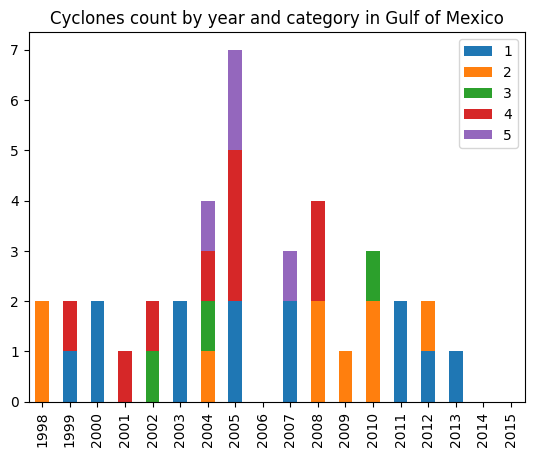

In [38]:
# Display cyclones by category for each year
typhoonCountByYear = pd.DataFrame(index=cyclonesMapData["YEAR_TIME"].unique())
for category in categoryLabels[1:]:
    typhoonCountByYear[category] = cyclonesMapData[["YEAR_TIME", "CATEGORY"]][cyclonesMapData["CATEGORY"] == category].groupby("YEAR_TIME").count()["CATEGORY"]
figure(figsize=(20, 7))
typhoonCountByYear[["1", "2", "3","4", "5"]].plot.bar(stacked=True, title='Cyclones count by year and category in ' + zoneAnalysis)

In [34]:
typhoonCountByYear

,TD,TS,1,2,3,4,5
1998,NaN,4,NaN,2.0,NaN,NaN,NaN
1999,4.0,1,1.0,NaN,NaN,1.0,NaN
2000,3.0,2,2.0,NaN,NaN,NaN,NaN
2001,NaN,4,NaN,NaN,NaN,1.0,NaN
2002,2.0,4,NaN,NaN,1.0,1.0,NaN
2003,1.0,4,2.0,NaN,NaN,NaN,NaN
2004,NaN,2,NaN,1.0,1.0,1.0,1.0
2005,NaN,5,2.0,NaN,NaN,3.0,2.0
2006,1.0,2,NaN,NaN,NaN,NaN,NaN
2007,2.0,2,2.0,NaN,NaN,NaN,1.0


<AxesSubplot: title={'center': 'Cyclones count by month and category in Japan'}, xlabel='MONTH_TIME'>

<Figure size 2000x700 with 0 Axes>

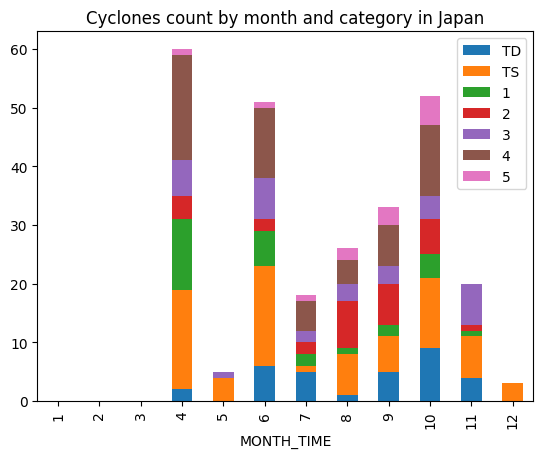

In [229]:
# Display cyclones by category for each month
typhoonCountByMonth = pd.DataFrame()
monthsInData = list(cyclonesMapData["MONTH_TIME"].unique())

for i in range(1, 12):
    if i not in monthsInData:
        monthsInData.append(i)

typhoonCountByMonth["MONTH_TIME"] = monthsInData
for category in categoryLabels[1:]:
     typhoonCountByMonth[category] = cyclonesMapData[["MONTH_TIME", "CATEGORY"]][cyclonesMapData["CATEGORY"] == category].groupby("MONTH_TIME", as_index=False).count()["CATEGORY"]
figure(figsize=(20, 7))

typhoonCountByMonth.sort_values("MONTH_TIME", inplace=True)

typhoonCountByMonth.plot.bar(x='MONTH_TIME', stacked=True, title='Cyclones count by month and category in ' + zoneAnalysis)

<AxesSubplot: title={'center': 'Average cyclones count by month in Japan'}, xlabel='MONTH_TIME'>

<Figure size 2000x700 with 0 Axes>

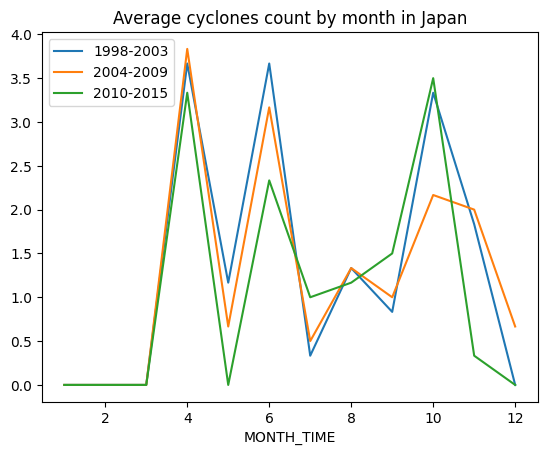

In [260]:
# Display average cyclone count by month for selected years bins

binSize = 6 #years count for each bin
#get months in order in dataset
typhoonCountByMonth = pd.DataFrame()
monthsInData = list(cyclonesMapData["MONTH_TIME"].unique())
for i in range(1, 12):
    if i not in monthsInData:
        monthsInData.append(i)
typhoonCountByMonth["MONTH_TIME"] = monthsInData

#get bins for years
yearList = cyclonesMapData.YEAR_TIME.unique()
yearList = [yearList[i] if i<len(yearList) else 2016 for i in range(0, len(yearList)+binSize, binSize)]

#extract data for months and years
for i in range(len(yearList)-1):
     typhoonCountByMonth[str(yearList[i])+"-"+str(yearList[i+1]-1)] = cyclonesMapData[["MONTH_TIME", "YEAR_TIME"]][(cyclonesMapData["YEAR_TIME"] >= yearList[i]) & (cyclonesMapData["YEAR_TIME"] < yearList[i+1])].groupby("MONTH_TIME", as_index=False).count()["YEAR_TIME"]/binSize
figure(figsize=(20, 7))

#sort by months and add 0 for missing data
typhoonCountByMonth.sort_values("MONTH_TIME", inplace=True)
typhoonCountByMonth.fillna(0, inplace=True)

#plot
typhoonCountByMonth.plot(x='MONTH_TIME', title='Average cyclones count by month in ' + zoneAnalysis)

# Dataset saving

In [60]:
usefullData = dataSpace[["LAT", "LON", "SID", "USA_WIND", "CATEGORY", "NSEC_TIME", "ISO_TIME"]]
usefullData

,LAT,LON,SID,USA_WIND,CATEGORY,NSEC_TIME,ISO_TIME
133928,25.299999,267.700012,1998233N25268,25.0,TD,903679200000000000,1998-08-21 06:00:00
133929,25.306000,266.864990,1998233N25268,27.0,TD,903690000000000000,1998-08-21 09:00:00
133930,25.400000,266.200012,1998233N25268,30.0,TD,903700800000000000,1998-08-21 12:00:00
133931,25.646999,265.804993,1998233N25268,35.0,TS,903711600000000000,1998-08-21 15:00:00
133932,26.000000,265.500000,1998233N25268,40.0,TS,903722400000000000,1998-08-21 18:00:00
...,...,...,...,...,...,...,...
237582,28.200001,263.299988,2015167N27266,50.0,TS,1434473100000000000,2015-06-16 16:45:00
237583,28.200001,263.299988,2015167N27266,50.0,TS,1434477600000000000,2015-06-16 18:00:00
237584,28.514999,263.226013,2015167N27266,45.0,TS,1434488400000000000,2015-06-16 21:00:00
237585,29.100000,263.100006,2015167N27266,40.0,TS,1434499200000000000,2015-06-17 00:00:00


In [62]:
usefullData.to_csv("data/ibtracs-"+zoneAnalysis.lower()+"-1998-2015.csv", index_label=False)